<a href="https://colab.research.google.com/github/astopchatyy/Buildings-prediction-collab/blob/main/Torch_training_(Buildings_dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import torch
import copy
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.stats import zscore
from xgboost import XGBRegressor

In [ ]:
drive.mount('/content/drive')
torch.manual_seed(1)
device = "cuda" if torch.cuda.is_available() else "cpu"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/collab files/buildings dataset/train.csv')
data.dropna(subset=['MasVnrArea', 'Electrical'], inplace=True)
data = data[data['LotArea'] <= data['LotArea'].quantile(0.99)]
data.drop('GarageYrBlt', axis=1, inplace=True)
data.drop('Id', axis=1, inplace=True)
drop_list = list(['GarageYrBlt', 'Id'])

In [ ]:
numeric_columns = data.columns[data.columns.map(lambda x: data[x].dtype != np.dtype(object) and len(data[x].unique()) > 10 and not 'Year' in x and x != 'MSSubClass' and x != 'SalePrice')]
numeric_columns

Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'TotRmsAbvGrd', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MiscVal', 'MoSold'],
      dtype='object')

In [ ]:
for column in data.columns:
  s = data[column].isna().sum()
  if s > len(data) * 0.75:
    data.drop(column, inplace=True, axis=1)
    drop_list.append(column)
  elif data[column].dtype == np.dtype(object) or column == 'MSSubClass':
    data = pd.concat([data, pd.get_dummies(data[column], prefix=column, dtype=int)], axis=1)
    data.drop(column, axis=1, inplace=True)
  elif s > 0:
    print(f"{column}: {s}")

LotFrontage: 251


In [ ]:
imputer = KNNImputer(n_neighbors=4)
data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

In [ ]:
for column in numeric_columns:
  data[column] = zscore(data[column])

In [ ]:
x = data.drop('SalePrice',axis=1)
y = data['SalePrice']

In [ ]:
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

def to_tensor(x):
    if isinstance(x, pd.DataFrame) or isinstance(x, pd.Series):
      x = x.values
    if not torch.is_tensor(x):
      device = "cuda" if torch.cuda.is_available() else "cpu"
      x = torch.tensor(x, device=device, dtype=torch.float32)
    return x

def to_numpy(x):
  if torch.is_tensor(x):
    return x.detach().cpu().numpy()
  elif isinstance(x, np.ndarray):
    return x
  return np.array(x)

class EarlyStopping:
  def __init__(self, model, loss_function, patience=5, min_delta=0):
    self.model = model
    self.loss_function = loss_function
    self.patience = patience
    self.min_delta = min_delta
    self.best_loss = None
    self.counter = 0

  def should_stop(self, x, y):
    self.model.eval()
    with torch.no_grad():
      out = self.model(x)
      loss = self.loss_function(out, y)
      if self.best_loss is None:
          self.best_loss = loss
      elif self.best_loss - loss >= self.min_delta:
          self.best_loss = loss
          self.counter = 0
      else:
          self.counter += 1
          if self.counter >= self.patience:
              return True
    return False

class ModelProcessor:
  def __init__(self, model, loss_function, optimizer=None, learning_rate=0.01, max_epoch=500, random_seed=None, early_stopping=False, es_patience=5):
    self.model = model
    self.loss_function = loss_function
    if not optimizer is None:
      self.optimizer = optimizer
    else:
      self.optimizer = torch.optim.Adam(self.model.parameters(), learning_rate)
    self.device = "cuda" if torch.cuda.is_available() else "cpu"
    self.max_epoch = max_epoch
    self.random_seed = random_seed
    self.last_epoch = 0
    self.early_stopping = early_stopping
    self.es_patience = es_patience

  def fit(self, x, y):
    if not self.random_seed is None:
      torch.manual_seed(self.random_seed)
    if self.early_stopping:
      x, x_valid, y, y_valid = train_test_split(x, y, test_size=0.2, random_state=self.random_seed)
      x_valid = to_tensor(x_valid)
      y_valid = to_tensor(y_valid).reshape(-1, 1)

    x = to_tensor(x)
    y = to_tensor(y).reshape(-1, 1)

    stopper = EarlyStopping(self.model, self.loss_function, patience=self.es_patience)

    for epoch in range(self.max_epoch):
      self.step(x, y)

      if self.early_stopping:
        if stopper.should_stop(x_valid, y_valid):
          break
    self.last_epoch = epoch



  def step(self, x, y):
    self.model.train()
    self.optimizer.zero_grad()
    out = self.model(x)
    loss = self.loss_function(out, y)
    loss.backward()
    self.optimizer.step()

  def predict(self, x):
    x = to_tensor(x)
    self.model.eval()
    return self.model(x)

In [ ]:
class RMSLELoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = torch.nn.MSELoss()

    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log(pred), torch.log(actual)))

In [ ]:
try_results = dict()

In [ ]:
x_train, x_test, y_train, try_test = train_test_split(x, y, test_size=0.25, random_state=20)

In [ ]:
from collections import OrderedDict

def try_nn(x, y, layers, validate_function, random_seed=None):
  device = "cuda" if torch.cuda.is_available() else "cpu"

  layers_dict = OrderedDict()
  for i, el in enumerate(layers):
    layers_dict[f"lin_{i}"] = torch.nn.Linear(el[0], el[1])
    if i != len(layers)-1:
      layers_dict[f"relu_{i}"] = torch.nn.ReLU()

  model = torch.nn.Sequential(layers_dict)
  model = torch.compile(model, backend="aot_eager").to(device)
  loss_function = torch.nn.MSELoss()
  processor = ModelProcessor(model, loss_function, random_seed=random_seed, max_epoch=5000, early_stopping=False, es_patience=50, learning_rate=0.01)

  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=random_seed)
  processor.fit(x_train, y_train)

  predicted = processor.predict(x_test)

  print(processor.last_epoch)
  global try_results
  try_results['nn'] = to_numpy(predicted.reshape(predicted.shape[0]))
  return validate_function(to_numpy(predicted.reshape(predicted.shape[0])), y_test)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

def try_gradient_boost(x, y, validate_function, random_seed=None):
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=random_seed)
  reg = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=40, max_features='sqrt', min_samples_leaf=10, min_samples_split=5, loss='huber', random_state=random_seed)
  reg.fit(x_train, y_train)
  predicted = np.maximum(0,reg.predict(x_test))
  global try_results
  try_results['gb'] = predicted
  return validate_function(predicted, y_test)

In [ ]:
def try_xgboost(x, y, validate_function, random_seed=None):
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=random_seed)
  xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     eval_metric='rmsle', nthread=-1,
                                     scale_pos_weight=1, seed=random_seed,
                                     reg_alpha=0.00006)

  xgboost.fit(x_train, y_train)
  predicted = np.maximum(0,xgboost.predict(x_test))
  global try_results
  try_results['xg'] = predicted
  return validate_function(predicted, y_test)


In [ ]:
def validate(predicted, actual):
  loss_function = RMSLELoss()
  plt.scatter(np.log(predicted), np.log(actual))
  plt.plot([np.log(np.min(actual)), np.log(np.max(actual))], [np.log(np.min(actual)), np.log(np.max(actual))])
  plt.show()
  p_t = to_tensor(predicted)
  a_t = to_tensor(actual)
  return to_numpy(loss_function(p_t, a_t))

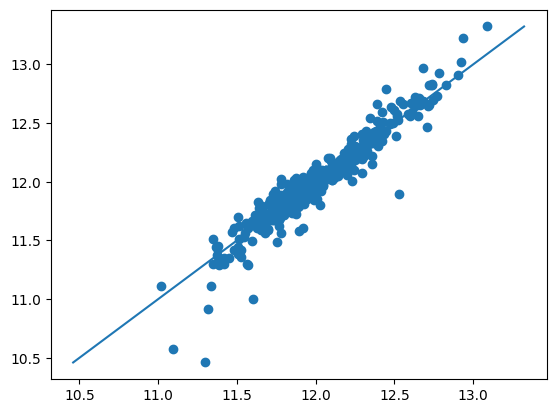

0.11892384


In [ ]:
seed=20
print(try_gradient_boost(x, y, validate, seed))

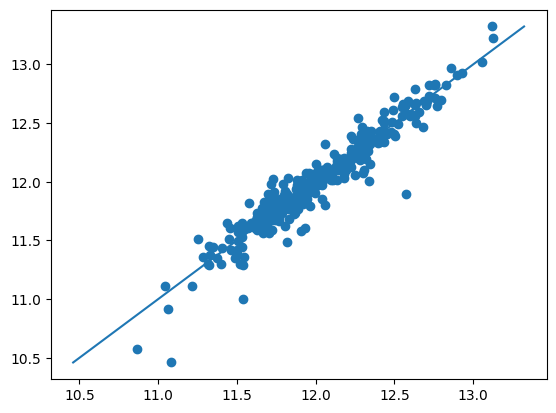

0.11116073


In [ ]:
seed=20
print(try_xgboost(x, y, validate, seed))

4999


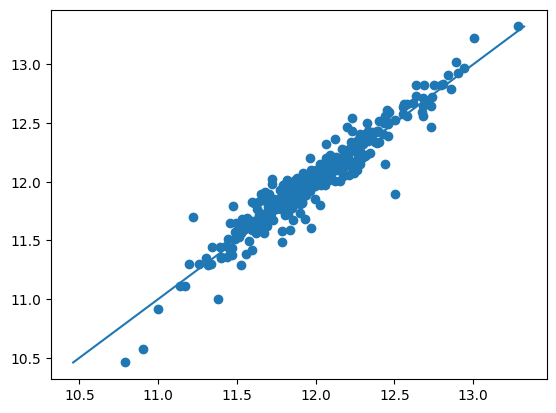

0.113869764


In [ ]:
seed=20
print(try_nn(x, y, [[x.shape[1], 200], [200, 100], [100, 100], [100, 1]], validate, random_seed=seed))

In [ ]:
corrs = data[numeric_columns].corrwith(data['SalePrice']).abs()

In [ ]:
def knn_weighter(columns):
  return [corrs[el] if el in numeric_columns else 0.1 for el in columns]

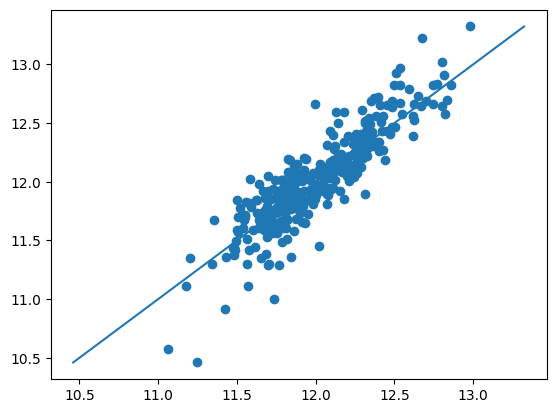

array(0.18238482, dtype=float32)

In [ ]:
neigh = KNeighborsRegressor(n_neighbors=3, weights='distance')
neigh.fit(x_train, y_train)
neigh_predict = neigh.predict(x_test)
validate(neigh_predict, try_test)

175376.92751743225
176717.81
172028.62


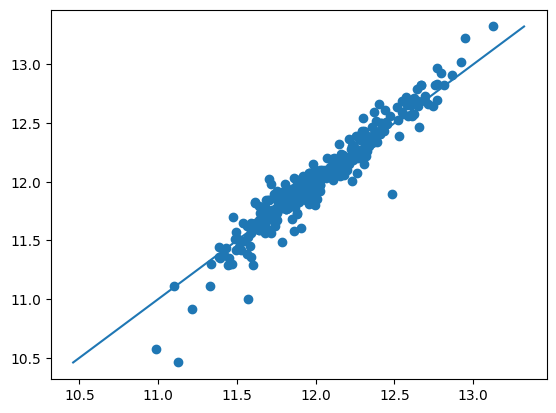

array(0.11162405, dtype=float32)

In [ ]:
try_mean = neigh_predict
i = 1
for key, el in try_results.items():
  print(el.mean())
  i+=1
  try_mean += np.array(el)
try_mean /= i
validate(try_mean, try_test)

In [ ]:
from collections import OrderedDict

def get_processor(layers, validate_function, random_seed=None):
  device = "cuda" if torch.cuda.is_available() else "cpu"

  layers_dict = OrderedDict()
  for i, el in enumerate(layers):
    layers_dict[f"lin_{i}"] = torch.nn.Linear(el[0], el[1])
    if i != len(layers)-1:
      layers_dict[f"relu_{i}"] = torch.nn.ReLU()

  model = torch.nn.Sequential(layers_dict)
  model = torch.compile(model, backend="aot_eager").to(device)
  loss_function = torch.nn.MSELoss()
  processor = ModelProcessor(model, loss_function, random_seed=random_seed, max_epoch=2000, early_stopping=False, es_patience=50, learning_rate=0.01)

  return processor

In [ ]:
test_data = pd.read_csv('/content/drive/MyDrive/collab files/buildings dataset/test.csv')
ids = test_data['Id']
test_data.drop(drop_list, axis=1, inplace=True)
for column in test_data.columns:
  if test_data[column].dtype == np.dtype(object):
      test_data = pd.concat([test_data, pd.get_dummies(test_data[column], prefix=column, dtype=int)], axis=1)
      test_data.drop(column, axis=1, inplace=True)

missing_columns = set(x.columns) - set(test_data.columns)
for column in missing_columns:
    test_data[column] = 0
test_data = test_data[x.columns]

imputer = KNNImputer(n_neighbors=4)
test_data = pd.DataFrame(imputer.fit_transform(test_data),columns=test_data.columns)

In [ ]:
seed=20

reg = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state=seed)
reg.fit(x, y)
predicted = np.maximum(0, reg.predict(test_data))

In [ ]:
predicted.mean()

178805.50220294506

In [ ]:
for column in numeric_columns:
  test_data[column] = zscore(test_data[column])

In [ ]:
from xgboost import XGBRegressor
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     scale_pos_weight=1, seed=seed,
                                     reg_alpha=0.00006)

xgboost.fit(x, y)
predicted3 = xgboost.predict(test_data)
predicted3.mean()

179634.27

In [ ]:
seed=15

processor = get_processor([[x.shape[1], 200], [200, 100], [100, 100], [100, 1]], validate, random_seed=seed)
processor.fit(x, y)
predicted2 = np.maximum(0, to_numpy(processor.predict(test_data)))
predicted2 = predicted2.reshape(predicted2.shape[0])
predicted2.mean()

185832.14

In [ ]:
res = (predicted + predicted2 + predicted3)/3
res.mean()

181423.96943389165

In [ ]:
pd.DataFrame(np.column_stack((ids, res)), columns=['Id', 'SalePrice']).astype({'Id': 'int32'}).to_csv("try.csv", index=False)

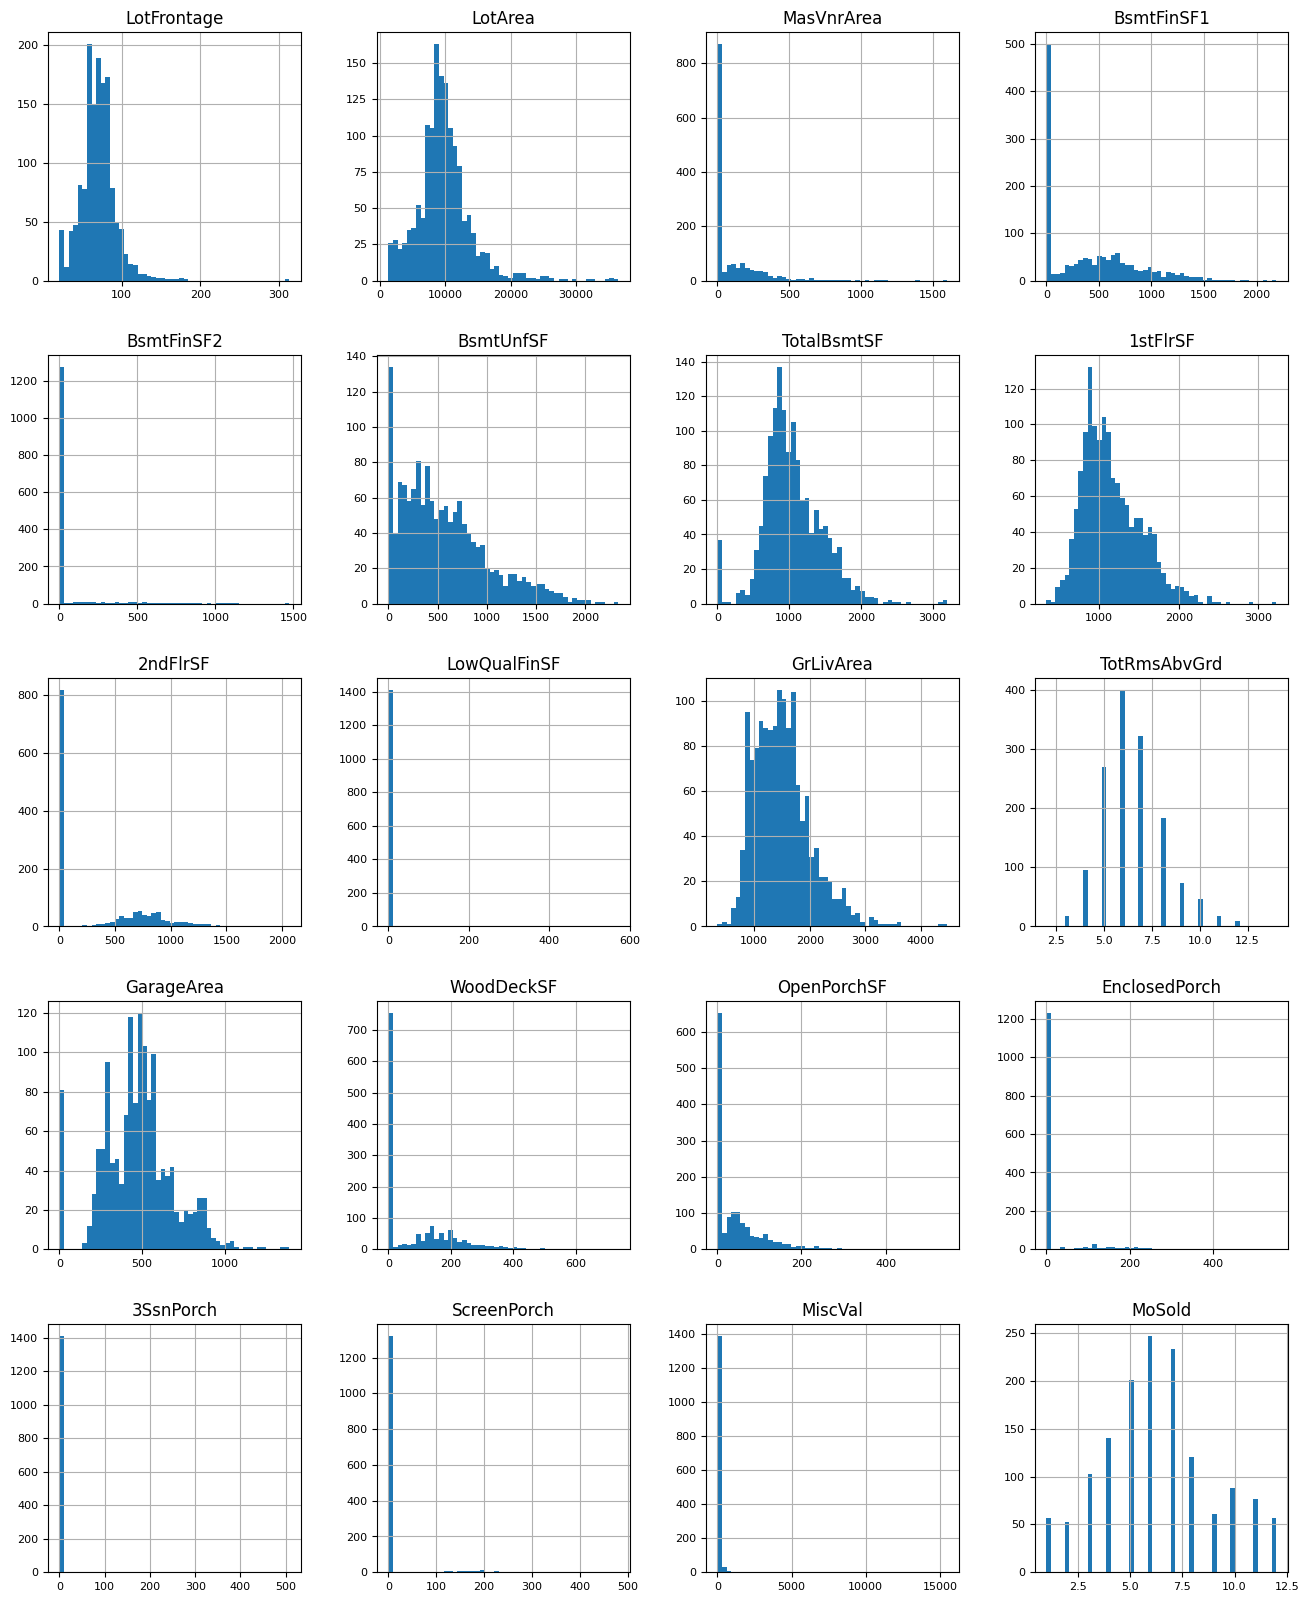

In [ ]:
data[numeric_columns].hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

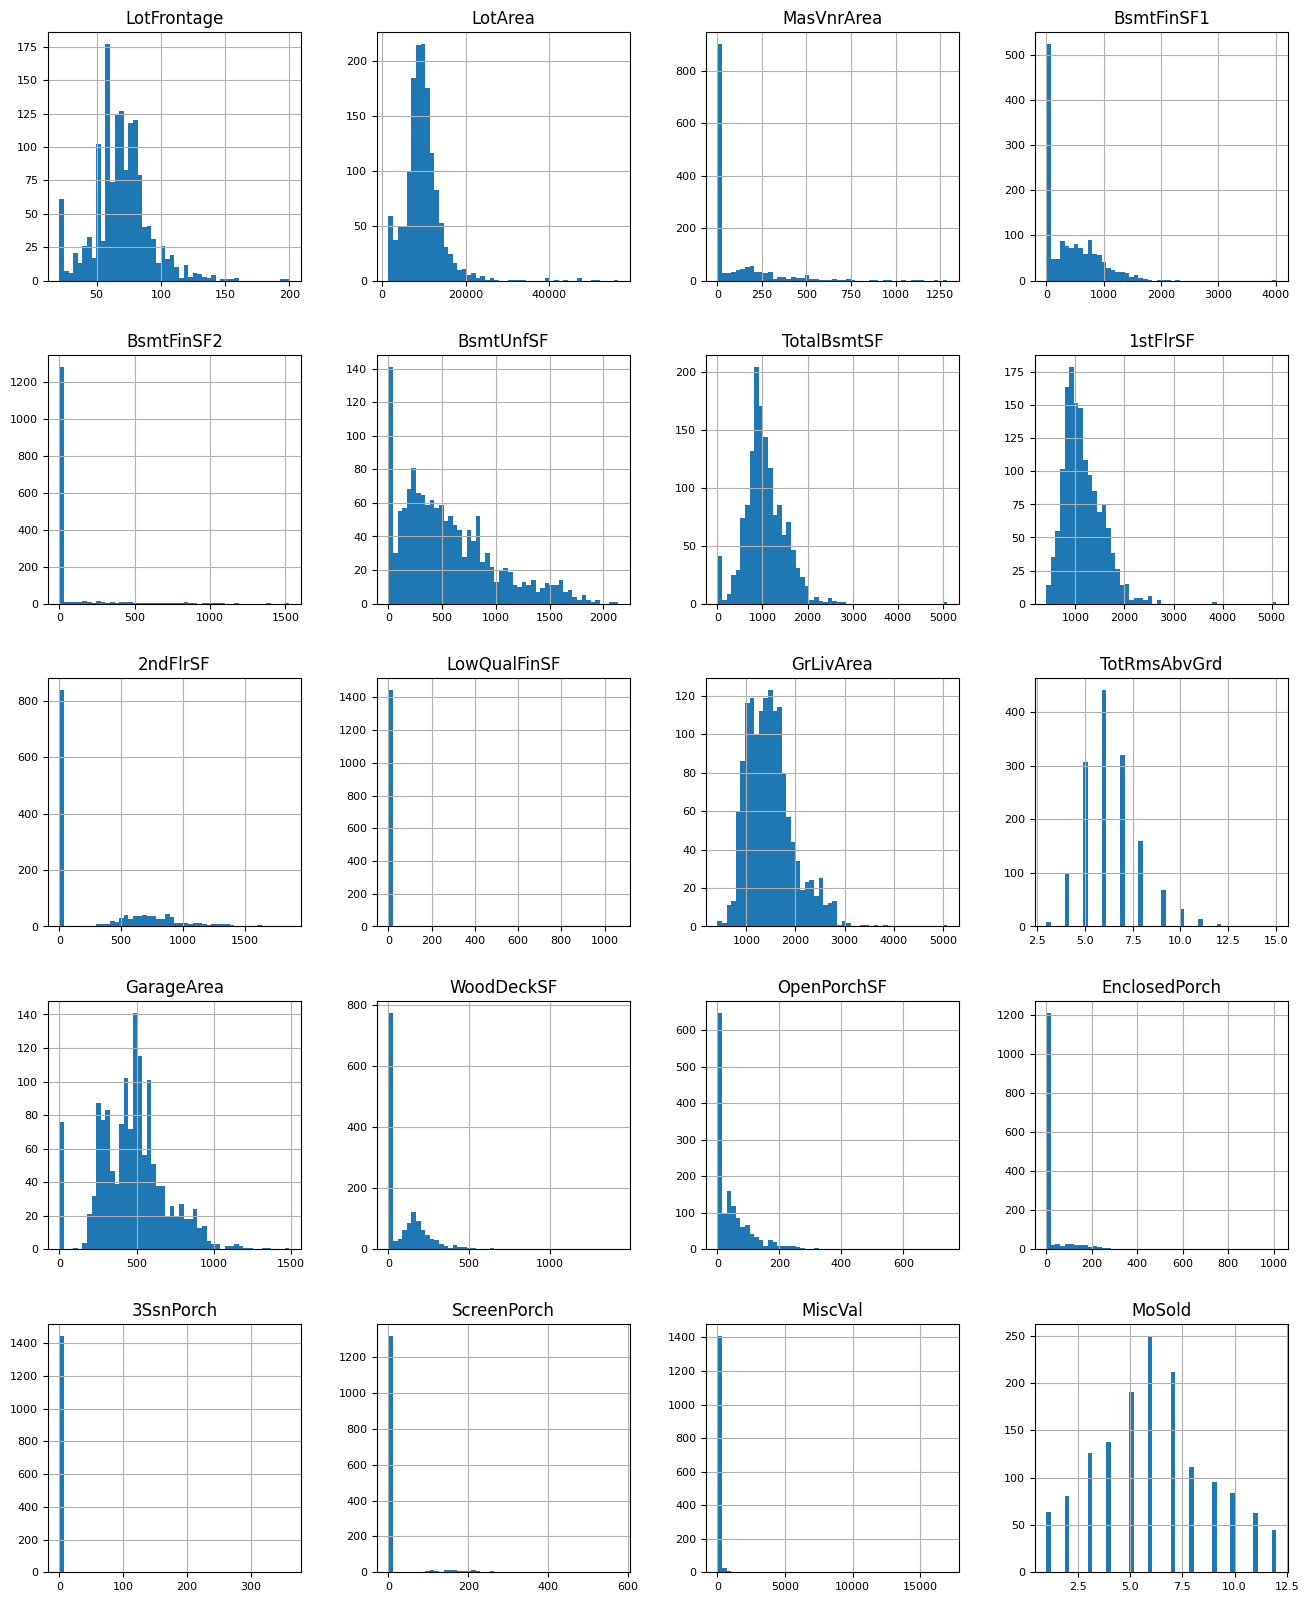

In [ ]:
test_data[numeric_columns].hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);